Neural Point Processes Notebook

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache
from tools.plot_utils import visualize_pins, plot_label_pin, plot_all, plot_and_save, plot_loss
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, train_model, evaluate_model
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder
import time
from tools.models import *

Dataset and Visualization

In [11]:
# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

In [12]:
dataset = "Synthetic"
feature_extracted = True
n = 100
mesh = True
d = 2
n_pins = 196
fixed_pins = True
r = 3
d1,d2 = 28,28
if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/{n}images_mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
    else:
        data_folder = f"./data/{folder}/{n}images_random_fixed{fixed_pins}_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"

if dataset == "Synthetic":
    if mesh:
        data_folder = f"./data/{folder}/{n}images_{d1}by{d2}pixels_{d}_distanced_grid_pins_{seed}seed/"
    else:
        data_folder = f"./data/{folder}/{n}images_{d1}by{d2}pixels_upto{n_pins}pins_{seed}seed/"

In [13]:
transform = transforms.Compose([
    ToTensor(),         # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"{data_folder}/images/",
                                      transform=transform)

In [14]:
dataset_size = len(transformed_dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Define batch size
batch_size = 64

def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]

    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs}

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

In [15]:
class CustomLRFinder:
    def __init__(self, model, criterion, optimizer, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.history = {'lr': [], 'loss': []}

    def find_lr(self, train_loader, start_lr=1e-4, end_lr=1, num_iter=10,smooth_f=0.05):
        model = self.model.to(self.device)
        criterion = self.criterion
        optimizer = self.optimizer
        device = self.device
        model.train()

        lr_step = (end_lr / start_lr) ** (1 / num_iter)
        lr = start_lr

        for iteration in range(num_iter):
            optimizer.param_groups[0]['lr'] = lr

            total_loss = 0.0
            for batch in train_loader:
                x_train = batch['image'][:, :input_channel, :, :].to(device)
                p_train = [tensor.to(device) for tensor in batch['pins']]
                y_train = [tensor.to(device) for tensor in batch['outputs']]

                optimizer.zero_grad()
                outputs = model(x_train.float())
                loss = criterion(y_train, outputs, p_train)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.history['lr'].append(lr)
            self.history['loss'].append(avg_loss)

            lr *= lr_step
            
    def plot_lr_finder(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')  # Use a logarithmic scale for better visualization
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder Curve')
        plt.show()
        
    def find_best_lr(self, skip_start=3, skip_end=3):
        # Find the index of the minimum loss in the specified range
        min_loss_index = skip_start + np.argmin(self.history['loss'][skip_start:-skip_end])

        # Output the learning rate corresponding to the minimum loss
        best_lr = self.history['lr'][min_loss_index]
        return best_lr

Best Learning Rate for MSE: 0.09999999999999996
Best Learning Rate for NPP sigma=0.1: 0.0251188643150958
Best Learning Rate for NPP sigma=0.2: 0.0251188643150958
Best Learning Rate for NPP sigma=0.5: 0.0251188643150958
Best Learning Rate for NPP sigma=1: 0.0251188643150958
Best Learning Rate for NPP sigma=2: 0.0251188643150958


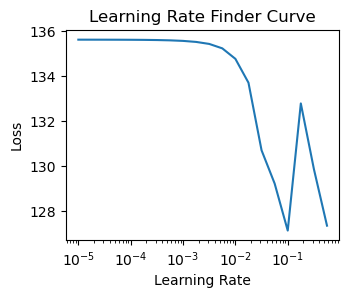

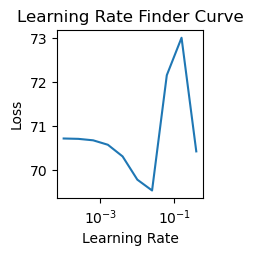

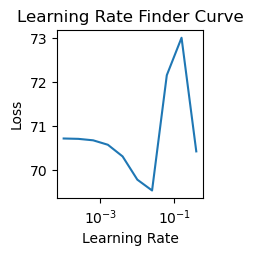

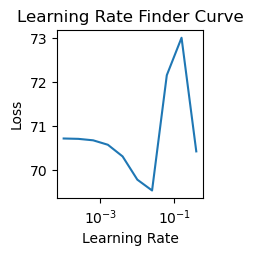

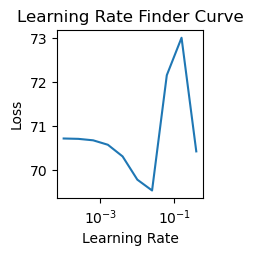

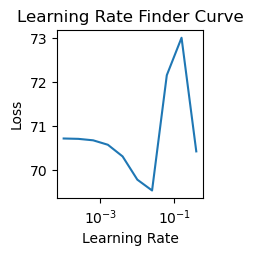

ValueError: num must be 1 <= num <= 6, not 7

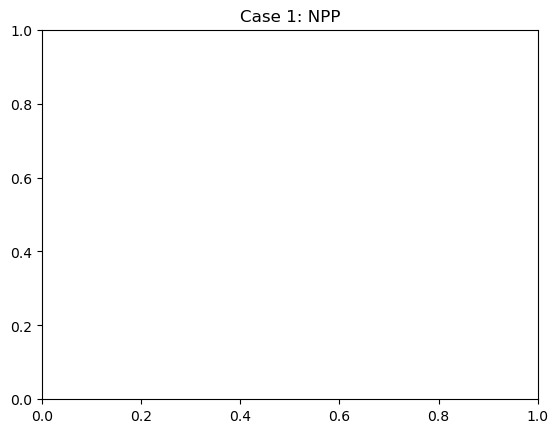

In [16]:
# Case 1: identity=True
# Set your hyperparameters
input_channel = 1 if dataset == "PinMNIST" else 3
num_epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2, 5]  # Set the sigma values you want to test
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
learning_rate = 0.01
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


criterion_MSE = NPPLoss(identity=True).to(device)
lr_finder_MSE = CustomLRFinder(model, criterion_MSE, optimizer, device=device)
lr_finder_MSE.find_lr(train_loader, start_lr=1e-5, end_lr=1, num_iter=20)
best_lr_MSE = lr_finder_MSE.find_best_lr()
print(f"Best Learning Rate for MSE: {best_lr_MSE}")


# Cases 2-6: identity=False, varying sigmas
best_lrs = [(0,best_lr_MSE)]

sigmas = [0.1, 0.2, 0.5, 1, 2]

for sigma in sigmas:
    criterion_NPP = NPPLoss(identity=False, sigma=sigma).to(device)
    lr_finder_NPP = CustomLRFinder(model, criterion_NPP, optimizer, device=device)
    lr_finder_NPP.find_lr(train_loader, start_lr=1e-4, end_lr=1, num_iter=10)
    best_lr_NPP = lr_finder_NPP.find_best_lr()
    best_lrs.append((sigma, best_lr_NPP))
    print(f"Best Learning Rate for NPP sigma={sigma}: {best_lr_NPP}")

# Plot learning rate finder curves
plt.figure(figsize=(12, 6))

# Case 1
plt.subplot(2, 3, 1)
lr_finder_MSE.plot_lr_finder()
plt.title("Case 1: MSE")

# Cases 2-6
for i, (sigma, best_lr) in enumerate(best_lrs, start=2):
    plt.subplot(2, 3, i)
    lr_finder_NPP.plot_lr_finder()
    plt.title(f"Case {sigma}: NPP")

plt.tight_layout()
plt.show()

print(best_lrs)

# PinMNIST
# Best Learning Rate for case 1: 0.04786300923226393
# Best Learning Rate for case 0.1: 0.08317637711026726
# Best Learning Rate for case 0.2: 0.04786300923226393
# Best Learning Rate for case 0.5: 0.00144543977074593
# Best Learning Rate for case 1: 0.04786300923226393
# Best Learning Rate for case 2: 0.2089296130854044
# Best Learning Rate for case 5: 0.0036307805477010196
# Best Learning Rate for case 10: 0.057543993733715805


# Synthetic
# 16 8
# Best Learning Rate for MSE: 0.005623413251903489
# Best Learning Rate for NPP sigma=0.1: 0.01
# Best Learning Rate for NPP sigma=0.2: 0.01
# Best Learning Rate for NPP sigma=0.5: 0.0039810717055349725
# Best Learning Rate for NPP sigma=1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=2: 0.0039810717055349725
# 32 16
# Best Learning Rate for MSE: 0.0003162277660168379
# Best Learning Rate for NPP sigma=0.1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=0.2: 0.0015848931924611134
# Best Learning Rate for NPP sigma=0.5: 0.0039810717055349725
# Best Learning Rate for NPP sigma=1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=2: 0.0015848931924611134
# n = 100, d = 2, mesh
# Best Learning Rate for MSE: 0.05623413251903489
# Best Learning Rate for NPP sigma=0.1: 0.0251188643150958
# Best Learning Rate for NPP sigma=0.2: 0.0251188643150958
# Best Learning Rate for NPP sigma=0.5: 0.0251188643150958
# Best Learning Rate for NPP sigma=1: 0.0251188643150958
# Best Learning Rate for NPP sigma=2: 0.0251188643150958

In [17]:
def run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device, num_runs=3):
    test_losses_npp_true = []
    test_losses_npp_false= []
    experiment_id = int(time.time())
    
    for run in range(num_runs):
        count = 0
        test_losses_vs_sigma_npp_true = []
        test_loss_npp_false = None

        # Run NPP=False once and collect the test loss
        early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
        criterion = NPPLoss(identity=True).to(device)

        autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
        
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
        model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, num_epochs,\
                                                      val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)

        test_loss_npp_false = evaluate_model(autoencoder, test_loader, input_channel, device)
        print(f"MSE Test loss:{test_loss_npp_false:.3f}")
        test_losses_npp_false.append(test_loss_npp_false)
        
        count += 1
        # Run LR Finder for different sigma values
        for sigma in sigmas:
            early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
            criterion = NPPLoss(identity=False, sigma=sigma).to(device)
            autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
            optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
            model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, num_epochs,\
                                                          val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)
            test_loss = evaluate_model(autoencoder, test_loader, input_channel, device)
            print(f"NPP sigma={sigma} Test loss:{test_loss:.3f}")
            test_losses_vs_sigma_npp_true.append(test_loss)
            count += 1

        test_losses_npp_true.append(test_losses_vs_sigma_npp_true)
    return test_losses_npp_true, test_losses_npp_false

    
# Function to run the pipeline and save data
def run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device):
    # Run the pipeline
    test_loss_npp_true, test_loss_npp_false= run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device)
    print("start saving!")
    # Save the data
    save_loss(test_loss_npp_true, './history/test_loss_npp_true.npy')
    save_loss(test_loss_npp_false, './history/test_loss_npp_false.npy')
    print("saved")
    return test_loss_npp_true, test_loss_npp_false

Validation Loss: 10.2711
Validation Loss: 10.4954
Validation Loss: 10.1172
Validation Loss: 10.0355
Validation Loss: 9.9005
Validation Loss: 9.7807
Validation Loss: 9.7358
Validation Loss: 9.6825
Validation Loss: 9.6653
Validation Loss: 9.6701
Validation Loss: 9.6790
Validation Loss: 9.7037
Validation Loss: 9.6991
Early stopping after 65 epochs.
MSE Test loss:6.848
Validation Loss: 10.4294
Validation Loss: 10.0726
Validation Loss: 10.0347
Validation Loss: 9.9557
Validation Loss: 9.7961
Validation Loss: 9.6818
Validation Loss: 9.6195
Validation Loss: 9.6332
Validation Loss: 9.6392
Validation Loss: 9.6256
Validation Loss: 9.6256
Early stopping after 55 epochs.
NPP sigma=0.1 Test loss:6.854
Validation Loss: 10.5552
Validation Loss: 10.5552
Validation Loss: 10.5552
Validation Loss: 10.5552
Validation Loss: 10.5552
Early stopping after 25 epochs.
NPP sigma=0.2 Test loss:7.792
Validation Loss: 10.5447
Validation Loss: 10.5447
Validation Loss: 10.5447
Validation Loss: 10.5447
Validation Loss:

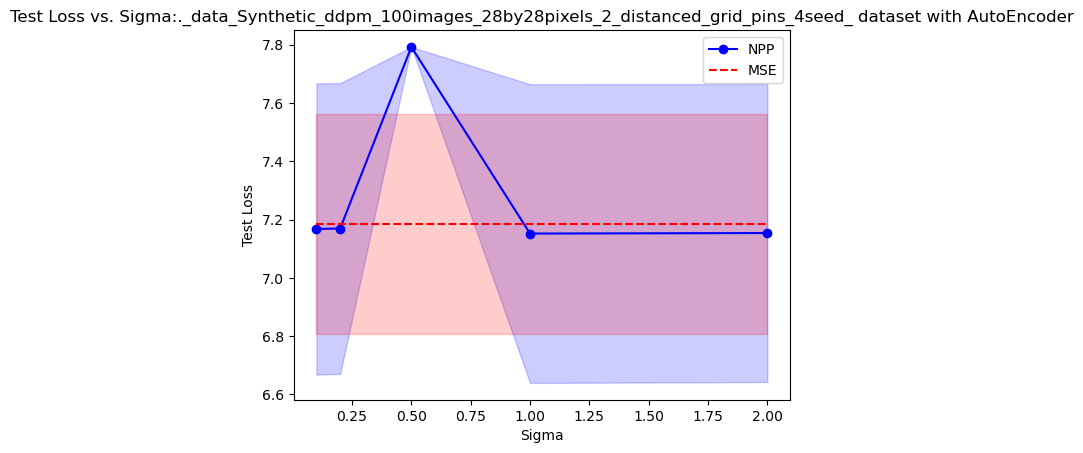

In [18]:
# Generate a unique experiment_id using a timestamp
  # Using timestamp as experiment_id

# Set your hyperparameters
# dataset = "MNIST"
input_channel = 1 if dataset == "MNIST" else 3
num_epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2]  # Set the sigma values you want to test
# best_lrs = [0.05, 0.05, 0.05, 0.05, 0.05, 0.001] #MNIST
# best_lrs = [0.1, 0.001, 0.001, 0.001, 0.001, 0.001] #Synthetic
best_lrs = [0.09999999999999996, 0.0251188643150958, 0.0015848931924611134, 0.0015848931924611134, 0.01, 0.0039810717055349725]
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
# learning_rate = 0.01
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run and save the pipeline data
loss_vs_sigma_data = run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader,\
                                           input_channel, num_epochs, val_every_epoch, best_lrs, device)


# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, data_folder.replace('/', '_'), learning_rate)